In [99]:
import pandas as pd
import numpy as np
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score
from sklearn import preprocessing
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [100]:
data = pd.read_csv("HR_comma_sep.csv")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_to_encode = ['sales','salary']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])
    
data = pd.get_dummies(data, columns=var_to_encode)

y = data['left']
X = data.drop(['left'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [101]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    
    results = {}
    
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])

    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)

    beta=0.5
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta)
    results['f_test'] = fbeta_score(y_test,predictions_test,beta)
       
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    return results

In [112]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
# Random state is not used.
clf_A = AdaBoostClassifier()
clf_B = DecisionTreeClassifier()
clf_C = GradientBoostingClassifier()
clf_D = RandomForestClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(X_train)
samples_10 = len(X_train)/10
samples_1 = len(X_train)/100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    #results[clf_name] = {}
    results[clf_name] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
#    for i, samples in enumerate([samples_1, samples_10, samples_100]):
#        results[clf_name][i] = \
#        train_predict(clf, samples, X_train, y_train, X_test, y_test)


AdaBoostClassifier trained on 11999 samples.
DecisionTreeClassifier trained on 11999 samples.
GradientBoostingClassifier trained on 11999 samples.
RandomForestClassifier trained on 11999 samples.


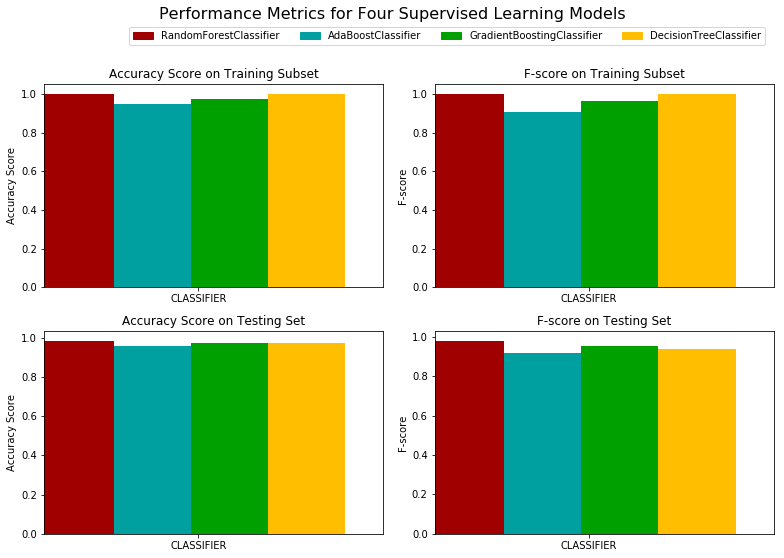

In [141]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score


fig, ax = pl.subplots(2, 2, figsize = (11,7))

# Constants
bar_width = 0.5
colors = ['#A00000','#00A0A0','#00A000','#FFBF00']

# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['acc_train', 'f_train','acc_test', 'f_test']):
#        for i in np.arange(3):
            # Creative plot code
        ax[j/2, j%2].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
        #ax[j/2, j%2].set_xticks([0.45, 1.45, 2.45])
        
        ax[j/2, j%2].set_xticks([0.8])
        ax[j/2, j%2].set_xticklabels(["CLASSIFIER"])
        ax[j/2, j%2].set_xlim((-0.2, 2.0))

# Add unique y-labels
ax[0, 0].set_ylabel("Accuracy Score")
ax[0, 1].set_ylabel("F-score")
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 1].set_ylabel("F-score")

# Add titles
ax[0, 0].set_title("Accuracy Score on Training Subset")
ax[0, 1].set_title("F-score on Training Subset")
ax[1, 0].set_title("Accuracy Score on Testing Set")
ax[1, 1].set_title("F-score on Testing Set")

patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))

    pl.legend(handles = patches, bbox_to_anchor = (-.9, 2.5), \
           loc = 'upper left', borderaxespad = 0., ncol = 4, fontsize = 'medium')

# Aesthetics
pl.suptitle("Performance Metrics for Four Supervised Learning Models", fontsize = 16, y = 1.10)
pl.tight_layout()
pl.show()

In [142]:
def modelfit(alg, X_train, y_train, predictors, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    y_pred = alg.predict(X_test)
    y_predprob = alg.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, X_train, y_train, cv=5, scoring='roc_auc')
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_test, y_predprob)
    
    print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #Print Feature Importance:
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.985
AUC Score (Train): 0.987670
CV Score : Mean - 0.9880965 | Std - 0.002524828 | Min - 0.9845416 | Max - 0.9920677


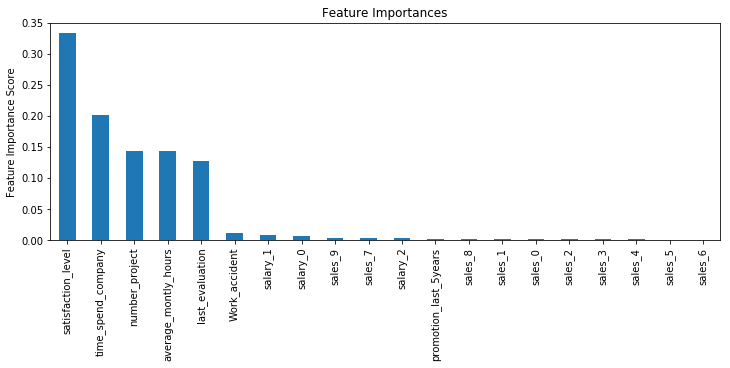

In [143]:
gbm0 = RandomForestClassifier(random_state=42)
predictors = [x for x in X_train.columns]
#print predictors
modelfit(gbm0, X_train, y_train,predictors)

In [178]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2, 
                                                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                                           bootstrap=True, oob_score=False, n_jobs=1, random_state=42,
                                                           warm_start=False, class_weight=None), 
                       param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [179]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.98858, std: 0.00131, params: {'n_estimators': 20},
  mean: 0.98900, std: 0.00119, params: {'n_estimators': 30},
  mean: 0.98892, std: 0.00136, params: {'n_estimators': 40},
  mean: 0.98908, std: 0.00138, params: {'n_estimators': 50},
  mean: 0.98925, std: 0.00119, params: {'n_estimators': 60},
  mean: 0.98883, std: 0.00130, params: {'n_estimators': 70},
  mean: 0.98875, std: 0.00156, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.9892492357926915)

In [182]:
param_test2 = {'max_depth':range(4,20,2), 'min_samples_split':range(2,11,1)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(criterion='gini', n_estimators=60, 
                                                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                                           bootstrap=True, oob_score=False, n_jobs=1, random_state=42, 
                                                           warm_start=False, class_weight=None), 
                       param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.91799, std: 0.00313, params: {'min_samples_split': 2, 'max_depth': 4},
  mean: 0.91791, std: 0.00307, params: {'min_samples_split': 3, 'max_depth': 4},
  mean: 0.91791, std: 0.00307, params: {'min_samples_split': 4, 'max_depth': 4},
  mean: 0.91799, std: 0.00313, params: {'min_samples_split': 5, 'max_depth': 4},
  mean: 0.91799, std: 0.00313, params: {'min_samples_split': 6, 'max_depth': 4},
  mean: 0.91799, std: 0.00313, params: {'min_samples_split': 7, 'max_depth': 4},
  mean: 0.91791, std: 0.00306, params: {'min_samples_split': 8, 'max_depth': 4},
  mean: 0.91791, std: 0.00306, params: {'min_samples_split': 9, 'max_depth': 4},
  mean: 0.91783, std: 0.00316, params: {'min_samples_split': 10, 'max_depth': 4},
  mean: 0.96666, std: 0.00302, params: {'min_samples_split': 2, 'max_depth': 6},
  mean: 0.96766, std: 0.00416, params: {'min_samples_split': 3, 'max_depth': 6},
  mean: 0.96658, std: 0.00415, params: {'min_samples_split': 4, 'max_depth': 6},
  mean: 0.96750, std: 0.003


Model Report
Accuracy : 0.9887
AUC Score (Train): 0.991341
CV Score : Mean - 0.9916642 | Std - 0.001396603 | Min - 0.9901975 | Max - 0.9937127


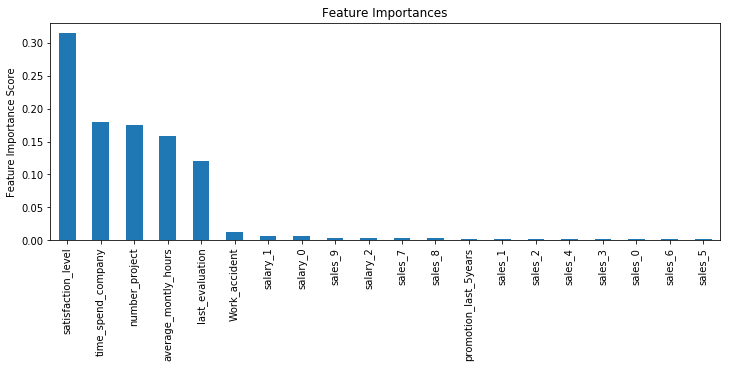

In [192]:
gmb_final = RandomForestClassifier(criterion='gini', min_samples_leaf=1, n_estimators=60, max_depth=18,min_samples_split=2,
                                                           random_state=42, n_jobs=1, min_impurity_decrease=0.0,min_weight_fraction_leaf=0.0)

modelfit(gmb_final, X_train, y_train,predictors)